In [82]:
import numpy as np
np.set_printoptions(precision=3, suppress=True, linewidth=100)


In [7]:
import mujoco
model = mujoco.MjModel.from_xml_path("../mujoco/release/model/humanoid/humanoid.xml")
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

In [27]:
! cat "../mujoco/release/model/humanoid/humanoid.xml"

<!-- Copyright 2021 DeepMind Technologies Limited

     Licensed under the Apache License, Version 2.0 (the "License");
     you may not use this file except in compliance with the License.
     You may obtain a copy of the License at

         http://www.apache.org/licenses/LICENSE-2.0

     Unless required by applicable law or agreed to in writing, software
     distributed under the License is distributed on an "AS IS" BASIS,
     WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
     See the License for the specific language governing permissions and
     limitations under the License.
-->

<mujoco model="Humanoid">
  <option timestep="0.005"/>

  <visual>
    <map force="0.1" zfar="30"/>
    <rgba haze="0.15 0.25 0.35 1"/>
    <global offwidth="2560" offheight="1440" elevation="-20" azimuth="120"/>
  </visual>

  <statistic center="0 0 0.7"/>

  <asset>
    <texture type="skybox" builtin="gradient" rgb1=".3 .5 .7" rgb2="0 0 0" width="32" height="512"/>
    <

""

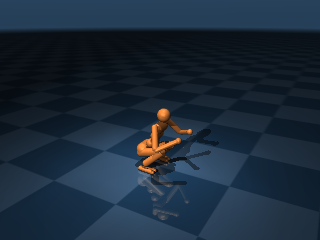

""

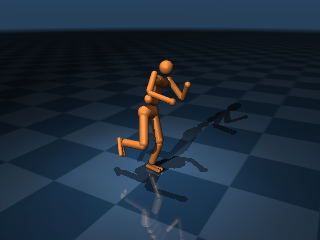

""

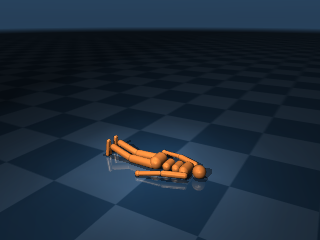

""

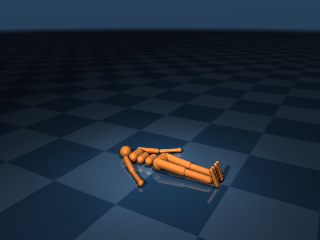

In [11]:
import mediapy as media

for key in range(model.nkey):
  mujoco.mj_resetDataKeyframe(model, data, key)
  mujoco.mj_forward(model, data)
  renderer.update_scene(data)
  media.show_image(renderer.render())

In [12]:
DURATION  = 3   # seconds
FRAMERATE = 60  # Hz

# Initialize to the standing-on-one-leg pose.
mujoco.mj_resetDataKeyframe(model, data, 1)
frames = []
while data.time < DURATION:
    # Step the simulation.
  mujoco.mj_step(model, data)

  # Render and save frames.
  if len(frames) < data.time * FRAMERATE:
    renderer.update_scene(data)
    pixels = renderer.render()
    frames.append(pixels)

# Display video.
media.show_video(frames, fps=FRAMERATE)

In [14]:
import numpy as np
DURATION  = 3   # seconds
FRAMERATE = 60  # Hz

# Make a new camera, move it to a closer distance.
camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 2

mujoco.mj_resetDataKeyframe(model, data, 1)

frames = []
while data.time < DURATION:
  # Set control vector. nu is num degrees of freedom
  data.ctrl = np.random.randn(model.nu)

  # Step the simulation.
  mujoco.mj_step(model, data)

  # Render and save frames.
  if len(frames) < data.time * FRAMERATE:
    # Set the lookat point to the humanoid's center of mass.
    camera.lookat = data.body('torso').subtree_com

    renderer.update_scene(data, camera)
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=FRAMERATE)

In [16]:
# Find the inverse dynamics at the desired setpoint
mujoco.mj_resetDataKeyframe(model, data, 1)
mujoco.mj_forward(model, data)
data.qacc = 0 # Assert no acceleration
mujoco.mj_inverse(model, data)
print(data.qfrc_inverse)

[ 0.00000000e+00  0.00000000e+00  2.75878566e+02 -3.31855341e+01
  4.99547913e+00 -6.68771278e+00 -4.30520866e+00  3.69324103e+00
 -1.54511509e+01 -1.09062996e+01  4.11835550e-01 -1.61300544e+00
 -9.79255144e+00 -2.31182930e+00 -3.66106442e-01 -5.91255024e+00
 -4.17112597e-01 -1.91408228e+00  5.75890779e+00  2.66518759e+00
 -2.02066315e-01 -5.75454992e+00  9.94329230e-01  1.14109244e+00
 -1.98740242e+00  3.82112740e+00  1.15105404e+00]


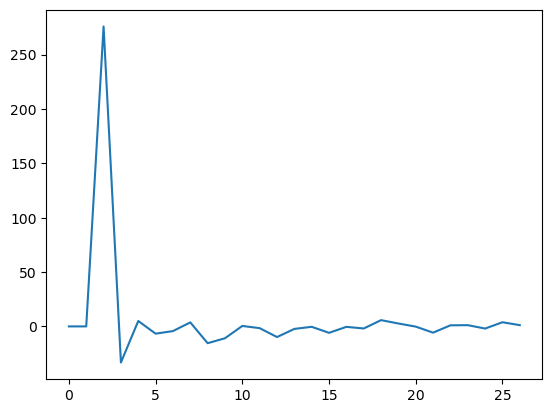

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(len(data.qfrc_inverse)), data.qfrc_inverse)

There is a force at the root joint - the free joint - shows that the model is not stationary, it is moving. It has a net force applied; it is accelerating.
There is a large force in the 3rd DoF, which is the vertical motion of the root joint.
This means that in order to explain our assertion that the acceleration is zero, the inverse dynamics has to invent a "magic" force applied directly to the root joint.

In [66]:
[print(x, model.joint(x).name) for x in range(model.njnt)]
print(data.joint('root').qpos)
print(data.joint('root').qvel)

0 root
1 abdomen_z
2 abdomen_y
3 abdomen_x
4 hip_x_right
5 hip_z_right
6 hip_y_right
7 knee_right
8 ankle_y_right
9 ankle_x_right
10 hip_x_left
11 hip_z_left
12 hip_y_left
13 knee_left
14 ankle_y_left
15 ankle_x_left
16 shoulder1_right
17 shoulder2_right
18 elbow_right
19 shoulder1_left
20 shoulder2_left
21 elbow_left
[ 0.         0.         1.21948    0.971588  -0.179973   0.135318
 -0.0729076]
[0. 0. 0. 0. 0. 0.]


Let's see how this force varies as we move our humanoid up and down by just 1mm, in increments of 1 𝜇 m:

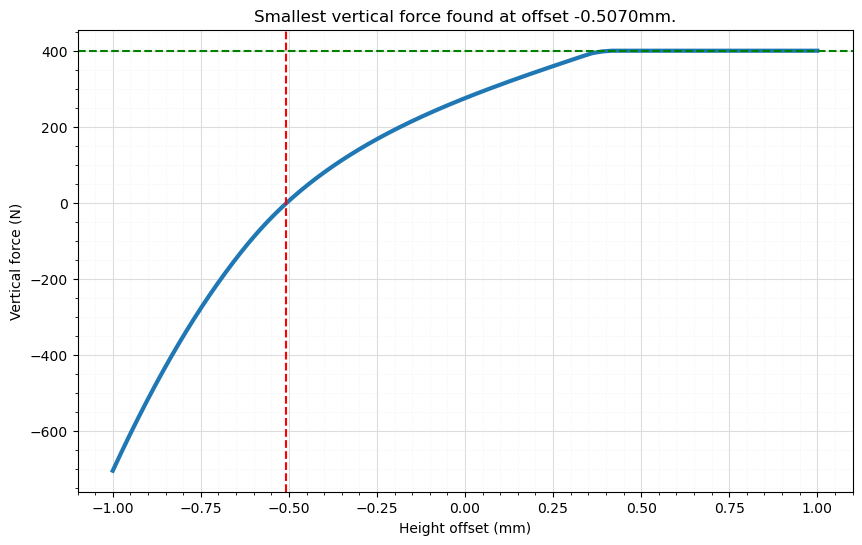

In [67]:
height_offsets = np.linspace(-0.001, 0.001, 2001)
vertical_forces = []
for offset in height_offsets:
  mujoco.mj_resetDataKeyframe(model, data, 1)
  mujoco.mj_forward(model, data)
  data.qacc = 0 # Assert no acceleration
  # Offset the height by `offset`.
  data.qpos[2] += offset
  mujoco.mj_inverse(model, data)
  vertical_forces.append(data.qfrc_inverse[2])

# Find the height-offset at which the vertical force is smallest.
idx = np.argmin(np.abs(vertical_forces))
best_offset = height_offsets[idx]

# Plot the relationship.
plt.figure(figsize=(10, 6))
plt.plot(height_offsets * 1000, vertical_forces, linewidth=3)
# Red vertical line at offset corresponding to smallest vertical force.
plt.axvline(x=best_offset*1000, color='red', linestyle='--')
# Green horizontal line at the humanoid's weight.
weight = model.body_subtreemass[1]*np.linalg.norm(model.opt.gravity)
plt.axhline(y=weight, color='green', linestyle='--')
plt.xlabel('Height offset (mm)')
plt.ylabel('Vertical force (N)')
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.minorticks_on()
plt.title(f'Smallest vertical force '
          f'found at offset {best_offset*1000:.4f}mm.')
plt.show()

This shows that as we move the robot up, the only way to explain its position is an external vertical force. This caps out at the weight of the robot.
As we move it down, the only way to explain it is a force pushing it into the ground.
At around -0.5, we have zero point with no external forces needed to explain.
Let's start the robot off at this best height.

In [70]:
mujoco.mj_resetDataKeyframe(model, data, 1)
mujoco.mj_forward(model, data)
data.qacc = 0
data.qpos[2] += best_offset
qpos0 = data.qpos.copy()  # Save the position setpoint.
mujoco.mj_inverse(model, data)
qfrc0 = data.qfrc_inverse.copy()
print('desired forces:', qfrc0)

desired forces: [  0.           0.          -0.19089622  -3.44739855   0.22200083
  -0.81682209   2.58562241  14.63721527 -18.64020189 -10.90629962
   0.41183555  -1.61300544  -9.79255144  -2.3118293   -0.36610644
 -23.75460252  -2.17102474  12.26376453  26.10082274  13.33685681
  -0.11304947  -5.75454992   0.99432923   1.14109244  -1.98740242
   3.8211274    1.15105404]


Now find actuator forces to create these. Each actuator has a moment arm, so we can get the inverse of this and multiply it by the forces, in effect dividing the forces by the moment arms.

In [75]:
print(np.atleast_2d(qfrc0))
# print(data.actuator_moment)
print(np.linalg.pinv(data.actuator_moment))

ctrl0 = np.atleast_2d(qfrc0) @ np.linalg.pinv(data.actuator_moment)
ctrl0 = ctrl0.flatten()  # Save the ctrl setpoint.
print('control setpoint:', ctrl0)


[[  0.           0.          -0.19089622  -3.44739855   0.22200083
   -0.81682209   2.58562241  14.63721527 -18.64020189 -10.90629962
    0.41183555  -1.61300544  -9.79255144  -2.3118293   -0.36610644
  -23.75460252  -2.17102474  12.26376453  26.10082274  13.33685681
   -0.11304947  -5.75454992   0.99432923   1.14109244  -1.98740242
    3.8211274    1.15105404]]
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        

In [76]:

data.ctrl = ctrl0
mujoco.mj_forward(model, data)
print('actuator forces:', data.qfrc_actuator)

actuator forces: [  0.           0.           0.           0.           0.
   0.           2.58562241  14.63721527 -18.64020189 -10.90629962
   0.41183555  -1.61300544  -9.79255144  -2.3118293   -0.36610644
 -23.75460252  -2.17102474  12.26376453  26.10082274  13.33685681
  -0.11304947  -5.75454992   0.99432923   1.14109244  -1.98740242
   3.8211274    1.15105404]


These forces are very close to the desired forces we calculated above. Obviously the root joint is different, but it's only small. Also, all the forces are within actuator limits (apparently?)
Let's apply to the model:

In [77]:
DURATION  = 3   # seconds
FRAMERATE = 60  # Hz

# Set the state and controls to their setpoints.
mujoco.mj_resetData(model, data)
data.qpos = qpos0
data.ctrl = ctrl0

frames = []
while data.time < DURATION:
  # Step the simulation.
  mujoco.mj_step(model, data)

  # Render and save frames.
  if len(frames) < data.time * FRAMERATE:
    # Set the lookat point to the humanoid's center of mass.
    camera.lookat = data.body('torso').subtree_com
    renderer.update_scene(data, camera)
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=FRAMERATE)

# It's stable for a bit and falls slower!

In [91]:
# Time to find Q and R for our LQR

# R is linear, and the matrices are just added and their combined scaling doesn't matter, so we can jsut choose identity for R
R = np.eye(model.nu) # nu is num of actuators
R.shape

(21, 21)

In [80]:
# Find a balancing cost that will keep the CoM over the foot.
# We use kinematic Jacobians to map between joint space and global Cartesian coords.

# instead of initialising to our keyframe, we initialise to our version with the height offset
mujoco.mj_resetData(model, data)
data.qpos = qpos0 
mujoco.mj_forward(model, data)

# Get jacobian for the root body (torso) CoM
jac_com = np.zeros((3, model.nv))
mujoco.mj_jacSubtreeCom(model, data, jac_com, model.body('torso').id)

# Get the Jacobian for the left foot.
jac_foot = np.zeros((3, model.nv))
mujoco.mj_jacBodyCom(model, data, jac_foot, None, model.body('foot_left').id)

jac_diff = jac_com - jac_foot # 3x27
Qbalance = jac_diff.T @ jac_diff

In [121]:
# Cost for joints moving away from their initial configuration
# The free joint will get a coefficient of 0, as that is already taken care of by the CoM cost term
# The joints required for balancing on the left leg, i.e. the left leg joints and the horizontal abdominal joints, should stay quite close to their initial values.
# All the other joints should have a smaller coefficient, so that the humanoid will, for example, be able to flail its arms in order to balance.

# Get all joint names.
joint_names = [model.joint(i).name for i in range(model.njnt)]

# Get indices into relevant sets of joints.
root_dofs = range(6)
body_dofs = range(6, model.nv)
abdomen_dofs = [
    model.joint(name).dofadr[0]
    for name in joint_names
    if 'abdomen' in name
    and not 'z' in name
]
left_leg_dofs = [
    model.joint(name).dofadr[0]
    for name in joint_names
    if 'left' in name
    and ('hip' in name or 'knee' in name or 'ankle' in name)
    and not 'z' in name
]

balance_dofs = abdomen_dofs + left_leg_dofs
other_dofs = np.setdiff1d(body_dofs, balance_dofs)

We are now ready to construct the Q matrix. Note that the coefficient of the balancing term is quite high. This is due to 3 separate reasons:
- It's the thing we care about most. Balancing means keeping the CoM over the foot.
- We have less control authority over the CoM (relative to body joints).
- In the balancing context, units of length are "bigger". If the knee bends by 0.1 radians (≈6°), we can probably still recover. If the CoM position is 10cm sideways from the foot position, we are likely on our way to the floor.

In [122]:
# Cost coefficients.
BALANCE_COST        = 2000  # Balancing.
BALANCE_JOINT_COST  = 3     # Joints required for balancing.
OTHER_JOINT_COST    = .3    # Other joints.

# Construct the Qjoint matrix.
Qjoint = np.eye(model.nv)
Qjoint[root_dofs, root_dofs] *= 0  # Don't penalize free joint directly.
Qjoint[balance_dofs, balance_dofs] *= BALANCE_JOINT_COST
Qjoint[other_dofs, other_dofs] *= OTHER_JOINT_COST

# Construct the Q matrix for position DoFs.
Qpos = BALANCE_COST * Qbalance + Qjoint

# No explicit penalty for velocities.
# Q 0
# 0 0
Q = np.block([[Qpos, np.zeros((model.nv, model.nv))],
              [np.zeros((model.nv, 2*model.nv))]])
Q.shape

(54, 54)

In [123]:
# Set the initial state and control.
mujoco.mj_resetData(model, data)
data.ctrl = ctrl0
data.qpos = qpos0

# Allocate the A and B matrices, compute them.
A = np.zeros((2*model.nv, 2*model.nv))
B = np.zeros((2*model.nv, model.nu))
epsilon = 1e-6
flg_centered = True
mujoco.mjd_transitionFD(model, data, epsilon, flg_centered, A, B, None, None)
A, B

(array([[ 1.   , -0.   ,  0.003, ..., -0.   ,  0.   , -0.   ],
        [ 0.   ,  1.   ,  0.001, ..., -0.   , -0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.988, ..., -0.   ,  0.   ,  0.   ],
        ...,
        [-0.   , -0.   ,  9.583, ...,  0.987, -0.002,  0.002],
        [ 0.   , -0.   , -8.924, ..., -0.002,  0.986,  0.005],
        [-0.   ,  0.   ,  3.382, ...,  0.002,  0.005,  0.982]]),
 array([[ 0.   ,  0.   , -0.   , ...,  0.   , -0.   ,  0.   ],
        [-0.   , -0.   ,  0.   , ...,  0.   ,  0.   , -0.   ],
        [ 0.   ,  0.   , -0.   , ...,  0.   , -0.   , -0.   ],
        ...,
        [-0.482,  0.451, -0.258, ...,  1.281,  0.211, -0.47 ],
        [-0.922, -0.5  ,  0.137, ...,  0.212,  1.361, -1.085],
        [ 0.515, -0.053,  0.033, ..., -0.236, -0.542,  3.664]]))

In [124]:
import scipy.linalg

# Solve discrete Riccati equation.
P = scipy.linalg.solve_discrete_are(A, B, Q, R)

# Compute the feedback gain matrix K.
K = np.linalg.inv(R + B.T @ P @ B) @ B.T @ P @ A

In [125]:
# Parameters.
DURATION = 5          # seconds
FRAMERATE = 60        # Hz

# Reset data, set initial pose.
mujoco.mj_resetData(model, data)
data.qpos = qpos0

# Allocate position difference dq.
dq = np.zeros(model.nv)

frames = []
while data.time < DURATION:
  # Get state difference dx.
  mujoco.mj_differentiatePos(model, dq, 1, qpos0, data.qpos)
  dx = np.hstack((dq, data.qvel)).T

  # LQR control law.
  data.ctrl = ctrl0 - K @ dx

  # Step the simulation.
  mujoco.mj_step(model, data)

  # Render and save frames.
  if len(frames) < data.time * FRAMERATE:
    renderer.update_scene(data)
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=FRAMERATE)

In [126]:
# Parameters.
DURATION = 5         # seconds
FRAMERATE = 60        # Hz
TOTAL_ROTATION = 15   # degrees
CTRL_RATE = 0.8       # seconds
BALANCE_STD = 0.01    # actuator units
OTHER_STD = 0.08      # actuator units

# Make new camera, set distance.
camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 2.3

# Enable contact force visualisation.
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True

# Set the scale of visualized contact forces to 1cm/N.
model.vis.map.force = 0.01

# Define smooth orbiting function.
def unit_smooth(normalised_time: float) -> float:
  return 1 - np.cos(normalised_time*2*np.pi)
def azimuth(time: float) -> float:
  return 100 + unit_smooth(data.time/DURATION) * TOTAL_ROTATION

# Precompute some noise.
np.random.seed(1)
nsteps = int(np.ceil(DURATION/model.opt.timestep))
perturb = np.random.randn(nsteps, model.nu)

# Scaling vector with different STD for "balance" and "other"
CTRL_STD = np.empty(model.nu)
for i in range(model.nu):
  joint = model.actuator(i).trnid[0]
  dof = model.joint(joint).dofadr[0]
  CTRL_STD[i] = BALANCE_STD if dof in balance_dofs else OTHER_STD

# Smooth the noise.
width = int(nsteps * CTRL_RATE/DURATION)
kernel = np.exp(-0.5*np.linspace(-3, 3, width)**2)
kernel /= np.linalg.norm(kernel)
for i in range(model.nu):
  perturb[:, i] = np.convolve(perturb[:, i], kernel, mode='same')

# Reset data, set initial pose.
mujoco.mj_resetData(model, data)
data.qpos = qpos0

# # Drop from a height
# data.qvel -= 0.2

# New renderer instance with higher resolution.
renderer = mujoco.Renderer(model, width=1280, height=720)

frames = []
step = 0
# while data.time < DURATION:
while step < nsteps:
  # Get state difference dx.
  mujoco.mj_differentiatePos(model, dq, 1, qpos0, data.qpos)
  dx = np.hstack((dq, data.qvel)).T

  # LQR control law.
  data.ctrl = ctrl0 - K @ dx

  # Add perturbation, increment step.
  data.ctrl += CTRL_STD * perturb[step]
  step += 1

  # Step the simulation.
  mujoco.mj_step(model, data)

  # Render and save frames.
  if len(frames) < data.time * FRAMERATE:
    camera.azimuth = azimuth(data.time)
    renderer.update_scene(data, camera, scene_option)
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=FRAMERATE)

In [127]:
Qbalance

array([[ 0.   ,  0.   ,  0.   , -0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.   ,  0.   , -0.   ,
        -0.   ,  0.   , -0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.   ,  0.   ,  0.   , -0.   ,
         0.   ,  0.   , -0.   ,  0.   , -0.   ],
       [ 0.   ,  0.   ,  0.   , -0.   , -0.   , -0.   , -0.   , -0.   , -0.   ,  0.   , -0.   ,
         0.   , -0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.   ,  0.   , -0.   ,  0.   ,  0.   ,
         0.   ,  0.   , -0.   , -0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , -0.   , -0.   , -0.   ,  0.   ,  0.   , -0.   , -0.   ,  0.   ,
         0.   , -0.   ,  0.   , -0.   , -0.   , -0.   ,  0.   ,  0.   ,  0.   , -0.   , -0.   ,
         0.   ,  0.   , -0.   ,  0.   ,  0.   ],
       [-0.   , -0.   , -0.   ,  0.612, -0.057,  0.134,  0.154, -0.036,  0.545, -0.042,  0.002,
         0.   ,  0.007, -0.   , -0.001, -0.524, -0.045, -0.026,  0.008, -0.005, -0.039, -0.006,
        -0.01 , -0.004,  0.008,  0.004,  0.001],
       [ 0.   , -0.   , -0.   , -0.0